# Compare Network Performance
Load in the results from the model trainings, and evaluate their performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.benchmark import load_benchmark_data
from sklearn.metrics import mean_absolute_error
from pathlib import Path
from tqdm import tqdm
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import json
import os

## Load in the Test Data
We are going to use it to validate our models

In [2]:
_, test_data = load_benchmark_data()

In [3]:
baseline_water = (test_data['sol_water'] - test_data['sol_water'].mean()).abs().mean()
print(f'Baseline: {baseline_water:.2f}')

Baseline: 3.28


## Score All Models
Run all models on the test sets, store results in DataFrame

In [4]:
models = glob(os.path.join('networks', '**', 'test_results.csv'), recursive=True)

In [5]:
def score_model(path):
    """Given a log file, parse the settings for the network and the epoch time / ending val_loss
    
    Args:
        path (str): Get the path 
    """
    
    # Get the metadata from the `config.json` file
    path = Path(path)
    with open(path.parent / 'config.json') as fp:
        metadata = json.load(fp)
    metadata['path'] = path.parent
       
    # Score the model on the target variable
    with open(path.parent.parent / 'options.json') as fp:
        options = json.load(fp)
    output = options['output_props']
    metadata['output_variables'] = output
    
    # Load in the log
    log = pd.read_csv(path.parent / 'train_log.csv')
    metadata['epochs'] = len(log)
    metadata['median_epoch_time'] = np.percentile(log['epoch_time'], 50)
    metadata['total_time'] = log['epoch_time'].sum()
    metadata['best_loss'] = log['val_loss'].min()
    metadata['best_loss_epoch'] = log['val_loss'].idxmin()
    
    # Get the scores on the test set
    directory = path.parent
    test_data = pd.read_csv(path)
    pred_cols = [f'{x}_pred' for x in output]
    metadata['mae_all_outputs'] = mean_absolute_error(test_data[pred_cols], test_data[output])

    # Get the MAE on water only
    metadata['mae_water'] = mean_absolute_error(test_data['sol_water_pred'], test_data['sol_water'])
    return metadata

In [6]:
results = [score_model(x) for x in tqdm(models)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 30.00it/s]


In [7]:
results = pd.DataFrame(results)

In [8]:
results.sort_values('mae_water', ascending=True).to_csv('mpnn-results.csv', index=False)

## Evaluate the Models
Make sure that our models are working as expected

In [9]:
results.sort_values('mae_water', ascending=True)[['name', 'mae_water', 'total_time',
                                                  'num_epochs', 'batch_size', 'median_epoch_time']].head(10)

,name,mae_water,total_time,num_epochs,batch_size,median_epoch_time
1,dielectric-constant-softplus-charges,0.297692,102836.882012,2048,512,52.730240
7,dielectric-constant-softplus-mpnn-charges,0.432225,355947.653867,8192,512,43.444650
55,dielectric-constant-softplus_no-acn,0.433976,352534.230792,8192,512,43.033689
6,dielectric-constant-softplus,0.434499,357012.966743,8192,512,43.573144
58,multi-task_multi-dense,0.435211,371488.084442,8192,512,45.342758
46,single-task,0.440289,351152.459489,8192,512,42.852508
4,dielectric-constant-softplus,0.445563,178162.320187,4096,512,43.500324
56,multi-task,0.445598,352054.413482,8192,512,42.967364
8,dielectric-constant-softplus-mpnn-charges,0.453259,101259.042081,2048,512,51.491894
54,dielectric-constant-softplus_no-acn,0.458205,101053.484549,2048,512,51.398600


In [10]:
results.sort_values('mae_water', ascending=True).query('num_epochs==8192 and train_size==117232')\
    [['name', 'mae_water', 'total_time', 
      'epochs', 'batch_size', 'median_epoch_time']]

,name,mae_water,total_time,epochs,batch_size,median_epoch_time
7,dielectric-constant-softplus-mpnn-charges,0.432225,355947.653867,8192,512,43.444650
55,dielectric-constant-softplus_no-acn,0.433976,352534.230792,8192,512,43.033689
6,dielectric-constant-softplus,0.434499,357012.966743,8192,512,43.573144
58,multi-task_multi-dense,0.435211,371488.084442,8192,512,45.342758
46,single-task,0.440289,351152.459489,8192,512,42.852508
56,multi-task,0.445598,352054.413482,8192,512,42.967364
17,dielectric-constant-softplus-atomic-contrib,0.633913,513737.362490,8192,512,62.713254
47,dielectric-constant-softplus-atomic-contrib-fe...,0.736364,516657.509354,8192,512,63.061932


## Plot the Learning as Function of Epoch
Look for anomalous behavior

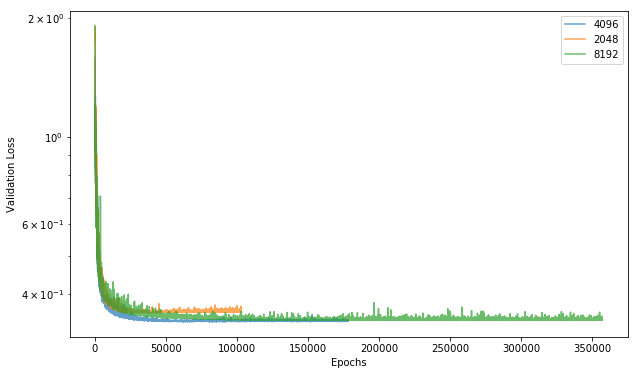

In [11]:
fig, ax = plt.subplots()

for _, f in results.query('name=="dielectric-constant-softplus"').iterrows():
    log = pd.read_csv(os.path.join(f['path'], 'train_log.csv'))
    ax.semilogy(log['epoch_time'].cumsum(), log['val_mean_absolute_error'], label=f['num_epochs'], alpha=0.7)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
ax.legend()
fig.set_size_inches(10, 6)

dielectric-constant-softplus best loss after 8192 epochs was at 1291 epochs: 0.2209128737449646
dielectric-constant-softplus-mpnn-charges best loss after 8192 epochs was at 1416 epochs: 0.204763725399971
dielectric-constant-softplus-atomic-contrib best loss after 8192 epochs was at 423 epochs: 0.3515715003013611
single-task best loss after 8192 epochs was at 214 epochs: 0.9950709939002992
single-task best loss after 8192 epochs was at 141 epochs: 1.6088789701461792
single-task best loss after 8192 epochs was at 55 epochs: 3.551459550857544
single-task best loss after 8192 epochs was at 203 epochs: 1.459917068481445
single-task best loss after 8192 epochs was at 237 epochs: 2.8149704933166504
single-task best loss after 8192 epochs was at 266 epochs: 1.0101851224899292
single-task best loss after 8192 epochs was at 5794 epochs: 0.34854578971862793
dielectric-constant-softplus-atomic-contrib-featureless best loss after 8192 epochs was at 889 epochs: 0.4203064739704132
dielectric-constant

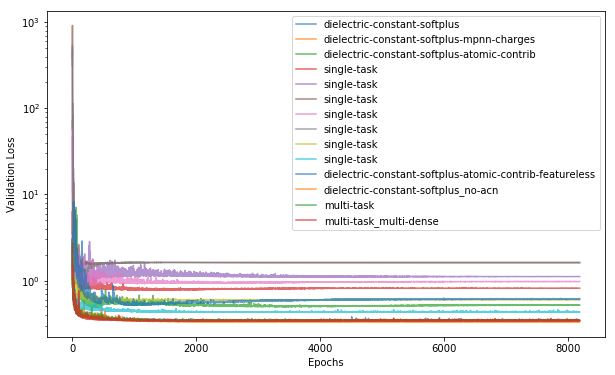

In [12]:
fig, ax = plt.subplots()

for _, f in results.query('num_epochs==8192').iterrows():
    log = pd.read_csv(os.path.join(f['path'], 'train_log.csv'))
    print('{} best loss after {} epochs was at {} epochs:'.format(f['name'], len(log), log['val_loss'].idxmin() + 1),
              log['val_loss'].min())
    ax.semilogy(log['epoch'], log['val_mean_absolute_error'], label=f['name'], alpha=0.7)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
#ax.set_xlim(0, 2000)
ax.legend()
fig.set_size_inches(10, 6)